In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn import svm, grid_search, datasets
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from scipy.ndimage.measurements import label
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split


/Users/SNAH/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/SNAH/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [6]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [7]:
# Read in cars and notcars
# images = glob.glob('*/*/*.jpeg')
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

print('车辆的样本数：')
print(len(notcars))
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 2000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

车辆的样本数：
8968


Text(0.5,1,'NotCar')

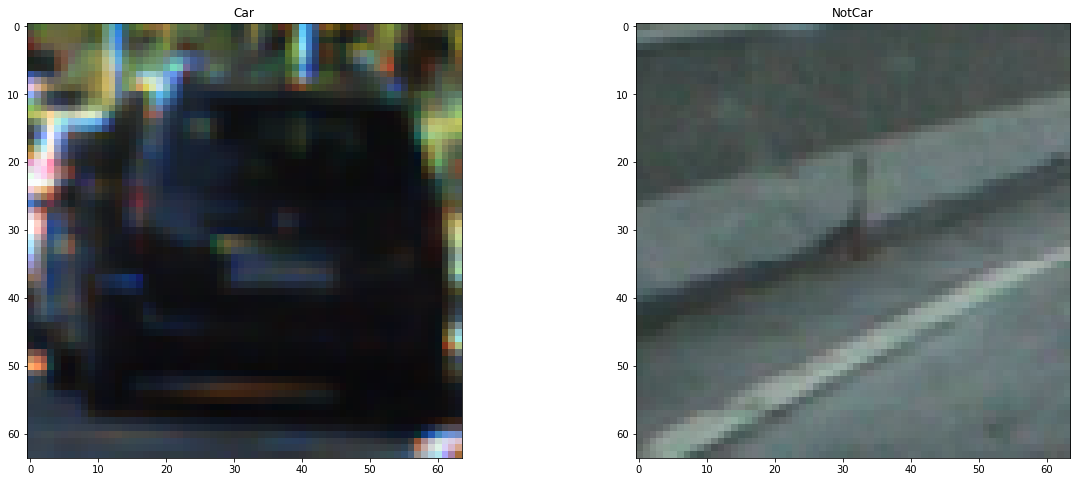

In [13]:
num_car = np.random.randint(0,len(cars))
num_notcar = np.random.randint(0,len(notcars))
car_image = mpimg.imread(cars[num_car])
notcar_image = mpimg.imread(notcars[num_notcar])
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('NotCar')

Text(0.5,1,'notcar_hog_img')

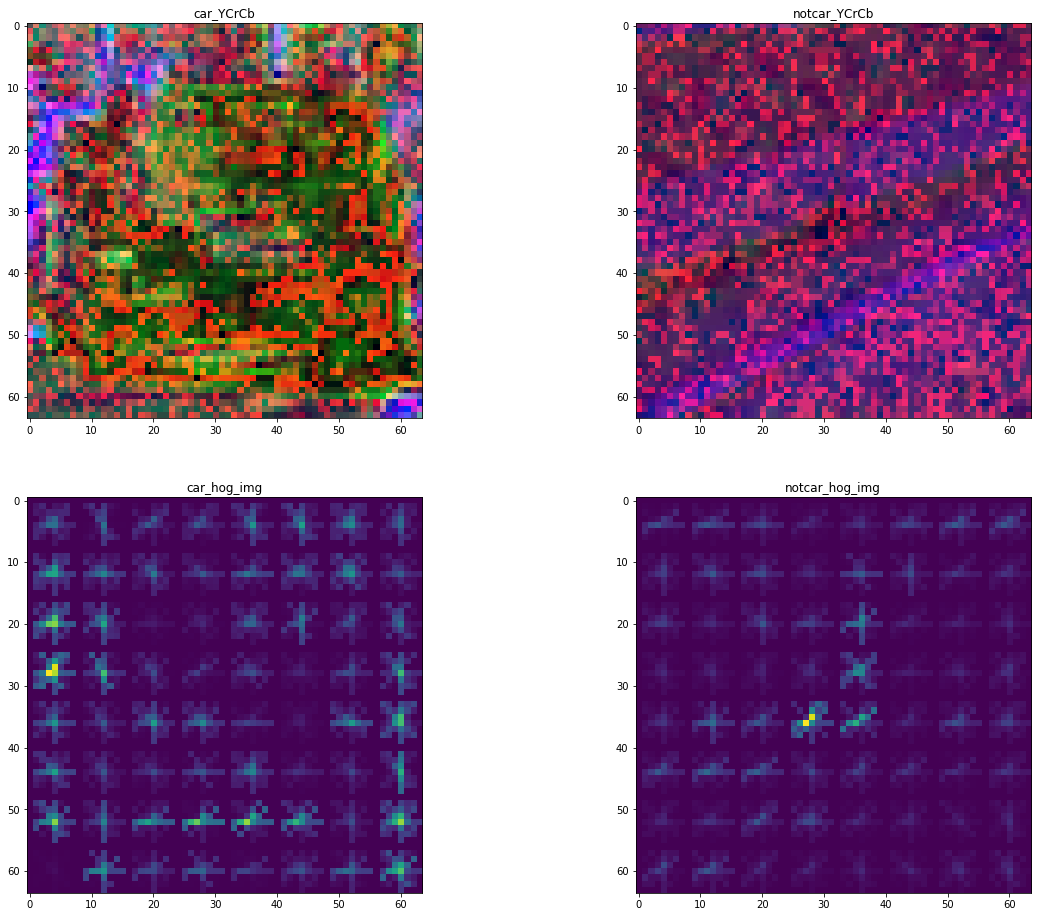

In [32]:
car_YCrCb = convert_color(car_image,conv = 'RGB2HSV')
notcar_YCrCb = convert_color(notcar_image,conv = 'RGB2HSV')
car_feature,car_hog_img = get_hog_features(car_YCrCb[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2,
                        vis=True, feature_vec=True)
notcar_feature,notcar_hog_img = get_hog_features(notcar_YCrCb[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2,
                        vis=True, feature_vec=True)
fig = plt.figure(figsize=(20,16))
plt.subplot(221)
plt.imshow(car_YCrCb)
plt.title('car_YCrCb')
plt.subplot(222)
plt.imshow(notcar_YCrCb)
plt.title('notcar_YCrCb')
plt.subplot(223)
plt.imshow(car_hog_img)
plt.title('car_hog_img')
plt.subplot(224)
plt.imshow(notcar_hog_img)
plt.title('notcar_hog_img')

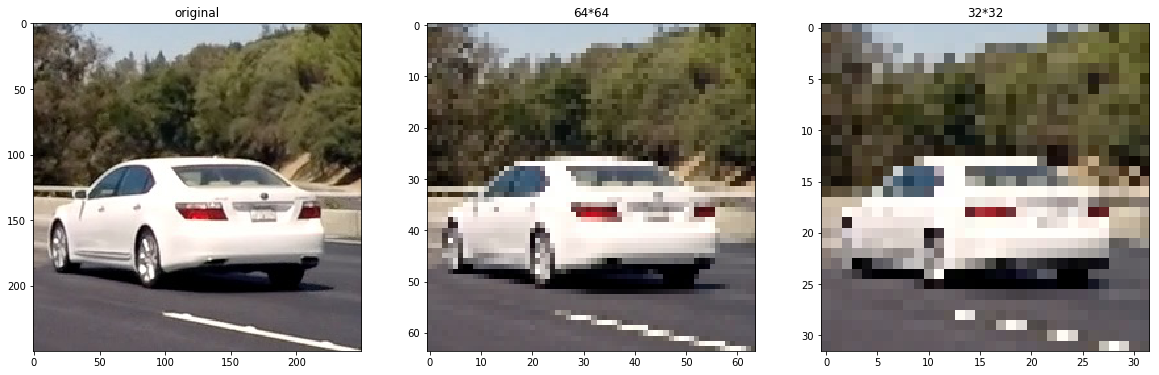

In [31]:
test_img = mpimg.imread('test_image.jpg')
# test_img = test_img[1030:1280,390:640,:]
test_img = test_img[300:550,1030:1280,:]
test_img2 = cv2.resize(test_img,(64,64))
test_img3 = cv2.resize(test_img,(32,32))
fig = plt.figure(figsize=[20,80])
plt.subplot(131)
plt.imshow(test_img)
plt.title('original')
plt.subplot(132)
plt.imshow(test_img2)
plt.title('64*64')
plt.subplot(133)
plt.imshow(test_img3)
plt.title('32*32')
plt.show()

In [36]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 650] # Min and max in y to search in slide_window()



In [39]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(len(car_features))
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print(X.shape)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
print(X_train.shape)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

8792
(17760, 6108)
(14208, 6108)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [40]:
# A dictionary of the parameters, and the possible values they may take.
parameters = {'C':[1,10,100], 'gamma':[2 ** x for x in range(-12, -10)]}
# Use a linear SVC
svr = svm.SVC()
# pass the algorithm (svr) and the dictionary of parameters to try (parameters) 
# and it generates a grid of parameter combinations to try.
clf = grid_search.GridSearchCV(svr, parameters)
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print(clf.best_params_)
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

2094.31 Seconds to train SVC...
{'gamma': 0.000244140625, 'C': 10}
Test Accuracy of SVC =  0.9913


In [45]:
import pickle
filename = 'svm_classifier.sav'
pickle.dump({'svc':clf,'X_scaler':X_scaler}, open(filename,'wb'))

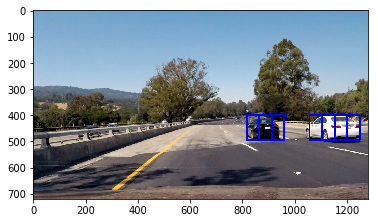

In [41]:

image = mpimg.imread('test_image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

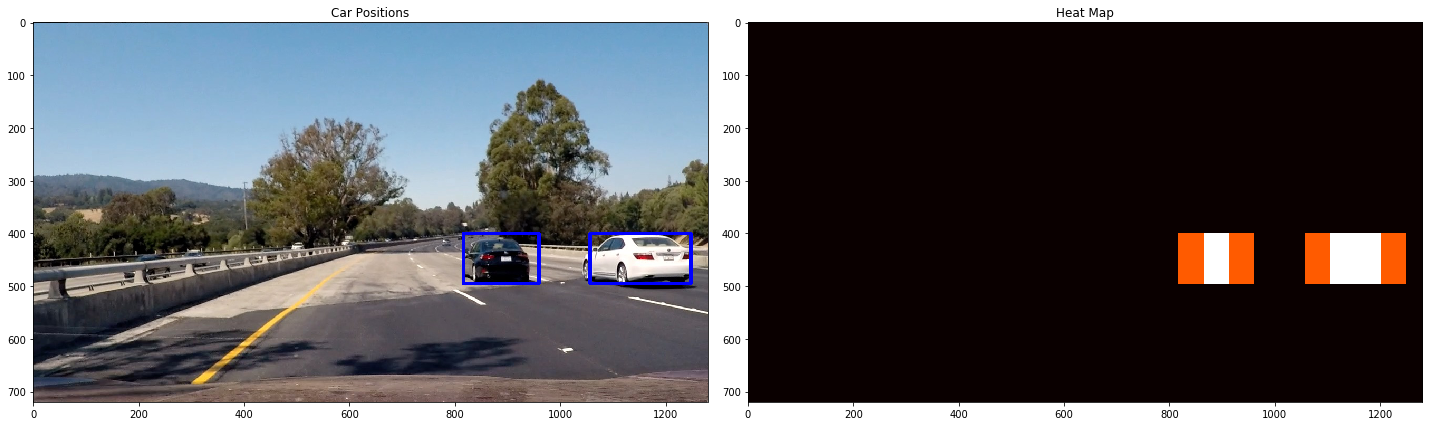

In [42]:
image_2 = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image_2[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image_2), labels)

fig = plt.figure(figsize=[20,80])
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [14]:
gammas = [2 ** x for x in range(-12, -10)]
print(gammas)

[0.000244140625, 0.00048828125]


In [33]:
test_filenames = glob.glob('output_images/test*.jpg')
print(test_filenames)
test_images=[]
for test_filename in test_filenames:
    test_image = mpimg.imread(test_filename)
    test_images.append(test_image)

['output_images/test6.jpg', 'output_images/test5.jpg', 'output_images/test4.jpg', 'output_images/test1.jpg', 'output_images/test3.jpg', 'output_images/test2.jpg']


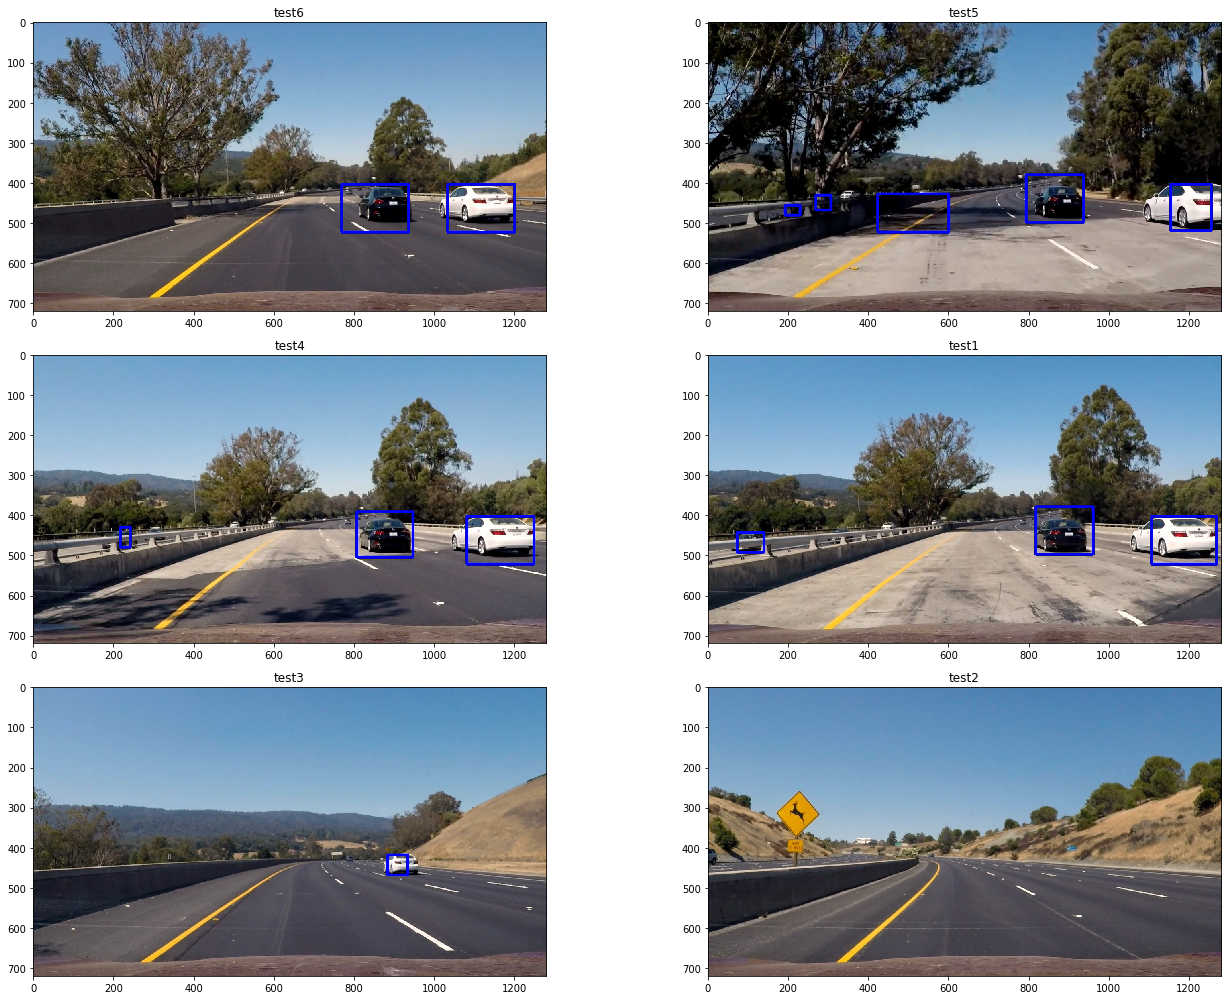

In [34]:

fig = plt.figure(figsize=[20,14])
plt.subplot(321)
plt.imshow(test_images[0])
plt.title('test6')
plt.subplot(322)
plt.imshow(test_images[1])
plt.title('test5')
plt.subplot(323)
plt.imshow(test_images[2])
plt.title('test4')
plt.subplot(324)
plt.imshow(test_images[3])
plt.title('test1')
plt.subplot(325)
plt.imshow(test_images[4])
plt.title('test3')
plt.subplot(326)
plt.imshow(test_images[5])
plt.title('test2')
fig.tight_layout()